In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.vectorized as sv
import os

In [4]:
def plot_result_map(file_path, case_name, title):
    """
    Plot the capacity factors of the world
    """

    dataset = xr.open_dataset(file_path)
    dataset.close()
    # Reindex the dataset to 0.25 degree resolution
    dataset = dataset.reindex(x=np.arange(-180, 180.25, 0.25), y=np.arange(-57, 85.25, 0.25), method='nearest')

    # Load the world shapefile
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    # Drop uninhabited regions and Antarctica
    region = world[(world.pop_est > 0) & (world.name != "Antarctica")]

    # Extract the geometry from the GeoSeries (use unary_union if there are multiple polygons)
    region_geom = region.unary_union if len(region) > 1 else region.iloc[0]

    # Get the grid of coordinates (lon, lat) from the xarray DataArray
    lon, lat = np.meshgrid(dataset['x'], dataset['y'], indexing='ij')

    # Use shapely's vectorized.contains to create a mask for points within the region
    mask = sv.contains(region_geom, lon, lat)

    # Apply the mask to the dataset DataArray
    masked_dataset = dataset.where(mask)

    # Plot the result with 1 step on x axis is the same as 1 step on y axis
    aspect_ratio = (dataset['x'].max()-dataset['x'].min())/(dataset['y'].max()-dataset['y'].min())
    masked_dataset['csp fraction'].plot(x='x', y='y', aspect=aspect_ratio, size=5, cmap='viridis', cbar_kwargs={'label': 'Breakeven cost of gas ($/MWh)'}, vmin=0, vmax=50)
    # Remove x and y labels and ticks
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('')
    # Add title
    plt.gca().set_title(title)
    # Remove box around the plot
    for edge in ['top', 'right', 'bottom', 'left']:
        plt.gca().spines[edge].set_visible(False)

    # Save the plot
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig(f'figures/csp_fraction_map_{case_name}.jpg', bbox_inches='tight', dpi=400)


/tmp/ipykernel_2478503/2237443397.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


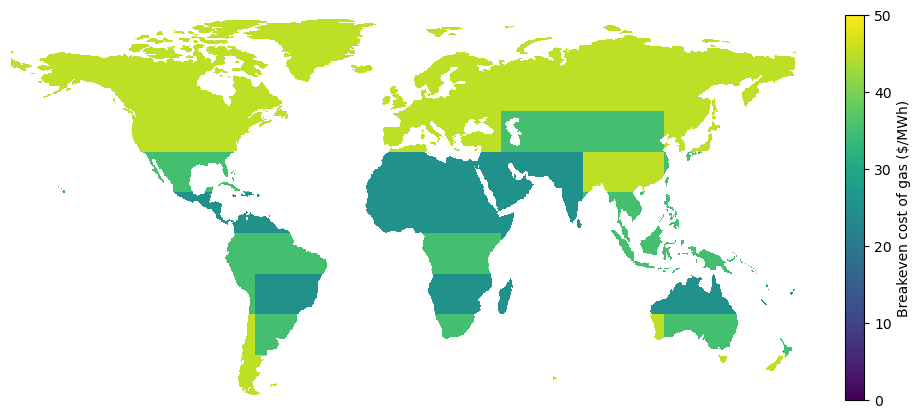

In [5]:
# Plot results
case = 'CSP'
for condition in ['deployed', 'dominating']:
    result_file = f'output_data/results_{case}.nc'

    if condition == 'deployed':
        title = 'Solar thermal deployed'
    else:
        title = 'Solar thermal > 50% of supply'
    plot_result_map(result_file, case, title)